In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [2]:
class Generator(nn.Module):
    # z_dim is the size of the input random noise vector
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 256) # Project noise to 256-dim
        self.fc2 = nn.Linear(256, 512) # Expand to 512-dim
        self.fc3 = nn.Linear(512, 1024) # Expand to 1024-dim
        self.fc4 = nn.Linear(1024, 3*32*32) # Output size = image size

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        z = self.fc1(z)
        z = self.relu(z)
        z = self.fc2(z)
        z = self.relu(z)
        z = self.fc3(z)
        z = self.relu(z)
        z = self.fc4(z)
        # z = self.tanh(z).view(-1, 1, 28, 28)  # Output values in range [-1, 1] & Reshape to image format
        z = self.tanh(z).view(-1, 3, 32, 32)  # Output values in range [-1, 1] & Reshape to image format

        return z

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 1024) # First hidden layer
        # self.fc1 = nn.Linear(28*28, 1024) # First hidden layer
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1) # Single output neuron representing the probability of the input image being real or fake

        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = img.view(-1, 3*32*32)  # Flatten the image
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.leaky_relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)  # Normalize the output to the range  [0,1]
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [7]:
z_dim = 100  # Latent vector size

# Initializing the Generator and Discriminator classes
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

In [8]:
loss_func = nn.BCELoss() # Binary Cross-Entropy Loss

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
num_epochs = 30

for epoch in range(num_epochs):
    running_d_loss = 0.0
    running_g_loss = 0.0
    for real_images, _ in dataloader:

        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Adversarial ground truths with dynamic batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)

        # Train the Discriminator
        optimizer_d.zero_grad()

        # Real images
        outputs = discriminator(real_images)
        d_loss_real = loss_func(outputs, real_labels)

        # Fake images
        z = torch.randn(current_batch_size, z_dim).to(device)  # Use current batch size for latent vector
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = loss_func(outputs, fake_labels)

        # Backpropagation for Discriminator
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Train the Generator
        generator.zero_grad()

        # Try to fool the discriminator with fake images
        outputs = discriminator(fake_images)
        g_loss = loss_func(outputs, real_labels)

        # Backpropagation for Generator
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

print('Training complete!')

Epoch [1/30], d_loss: 0.1329047977924347, g_loss: 3.814187526702881
Epoch [2/30], d_loss: 0.716196596622467, g_loss: 2.955000162124634
Epoch [3/30], d_loss: 0.05685514956712723, g_loss: 5.159906387329102
Epoch [4/30], d_loss: 0.046272777020931244, g_loss: 5.1286091804504395
Epoch [5/30], d_loss: 0.8274129629135132, g_loss: 2.6607120037078857
Epoch [6/30], d_loss: 0.3436295986175537, g_loss: 3.6422643661499023
Epoch [7/30], d_loss: 0.9022998809814453, g_loss: 4.290898323059082
Epoch [8/30], d_loss: 0.5579705834388733, g_loss: 2.9578044414520264
Epoch [9/30], d_loss: 1.1802107095718384, g_loss: 2.3096156120300293
Epoch [10/30], d_loss: 1.2494920492172241, g_loss: 2.0130791664123535
Epoch [11/30], d_loss: 0.6858630180358887, g_loss: 2.5259180068969727
Epoch [12/30], d_loss: 0.7593141794204712, g_loss: 1.8471286296844482
Epoch [13/30], d_loss: 0.801734209060669, g_loss: 2.0305609703063965
Epoch [14/30], d_loss: 1.0290278196334839, g_loss: 1.5757246017456055
Epoch [15/30], d_loss: 1.2410613

In [10]:
torch.save({
    'generator_state_dict': generator.state_dict(), # Saves the weights of the Generator
    'discriminator_state_dict': discriminator.state_dict(), # Saves the weights of the Discriminator
    'optimizer_g_state_dict': optimizer_g.state_dict(), # Saves the Generator optimizer state
    'optimizer_d_state_dict': optimizer_d.state_dict() # Saves the Discriminator optimizer state
},  'cifar10_GAN.pt')

print("Model saved!")

Model saved!


In [11]:
GAN_Model = torch.load('cifar10_GAN.pt')

# Re-initialize models and optimizers
generator = Generator(z_dim)  # Ensure img_dim=784

# Load model weights
generator.load_state_dict(GAN_Model['generator_state_dict'])

# Load optimizers (if continuing training)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

optimizer_g.load_state_dict(GAN_Model['optimizer_g_state_dict'])

generator.eval()

print("Generator loaded successfully!")

Generator loaded successfully!


C:\Users\4310129\AppData\Local\Temp\ipykernel_2088\2170943496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GAN_Model = torch.load('cifar10_GAN.pt')


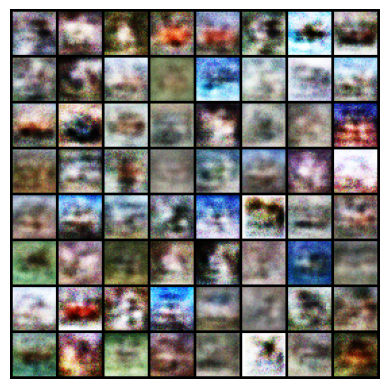

In [12]:
import matplotlib.pyplot as plt

# Generate random noise and use the generator to produce images
z = torch.randn(64, z_dim)
generated_imgs = generator(z).view(-1, 3, 32, 32)

# Create a grid of the generated images
grid_img = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2, normalize=True)

# Display the images
plt.imshow(grid_img.permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()